In [3]:
# Librerias

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Preprocesamiento y transformación
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.impute import SimpleImputer

# Balanceo
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Selección de características
from sklearn.feature_selection import RFE, SelectFromModel

# Modelado y validación
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Reducción dimensional
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Utilidades
from collections import Counter

#Finetouning
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score



# Carga de datos y generación de variables

In [4]:

ruta = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx"
df = pd.read_excel(ruta)

# Fechas
date_cols = ['fecha_creacion', 'fecha_pago', 'hasta el mes']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

# Días hasta el pago
df['dias_pago'] = (df['fecha_pago'] - df['fecha_creacion']).dt.days

# Mes y año creación/pago
df['mes_creacion'] = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year
df['mes_pago']    = df['fecha_pago'].dt.month
df['anio_pago']   = df['fecha_pago'].dt.year

# Variable objetivo 'moroso' (1=moroso, 0=no)
df['moroso'] = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)


# Análisis univariado (EDA)


--- monto (int64) ---
Únicos: 104 | Nulos: 0


count    15989.000000
mean       800.762399
std        495.399162
min          0.000000
25%        600.000000
50%        600.000000
75%        800.000000
max      19100.000000
Name: monto, dtype: float64

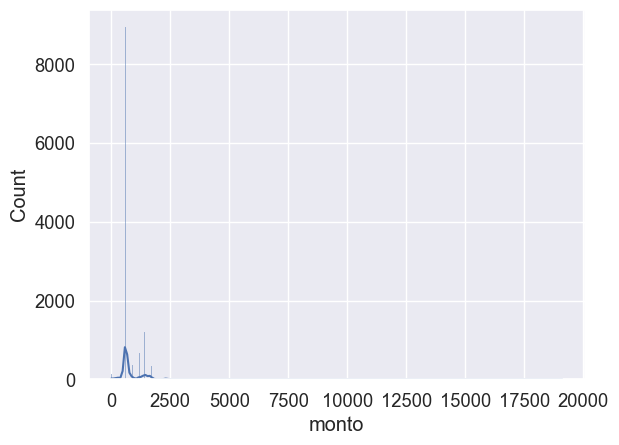


--- dias_pago (float64) ---
Únicos: 534 | Nulos: 5890


count    10099.000000
mean        69.852758
std        126.302000
min       -737.000000
25%         11.000000
50%         17.000000
75%         83.000000
max        743.000000
Name: dias_pago, dtype: float64

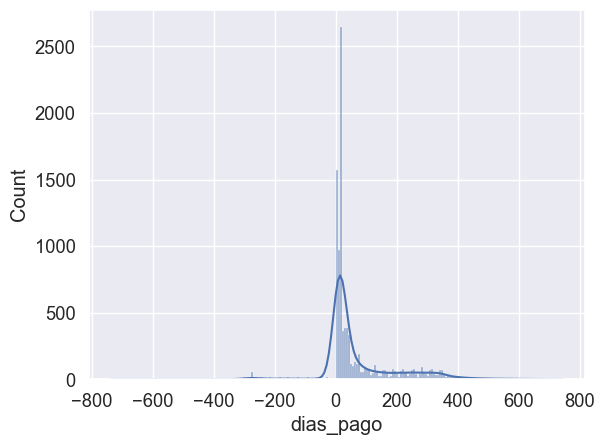


--- moroso (int32) ---
Únicos: 2 | Nulos: 0


count    15989.000000
mean         0.368378
std          0.482380
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: moroso, dtype: float64

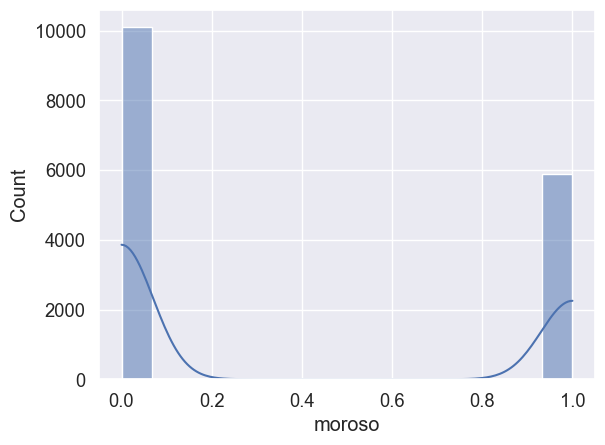

In [5]:

def eda_univariate(df, max_cat=10):
    for col in df.columns:
        print(f"\n--- {col} ({df[col].dtype}) ---")
        print("Únicos:", df[col].nunique(), "| Nulos:", df[col].isnull().sum())
        if pd.api.types.is_numeric_dtype(df[col]):
            display(df[col].describe())
            sns.histplot(df[col], kde=True); plt.show()
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            print("Rango:", df[col].min(), "a", df[col].max())
            df[col].dt.to_period('M').value_counts().sort_index().plot(); plt.show()
        else:
            vc = df[col].value_counts()
            print(vc.head(10))
            if vc.size <= max_cat:
                sns.countplot(y=col, data=df, order=vc.index); plt.show()
            else:
                print(f"— salto gráfica de {col} (niveles={vc.size} > {max_cat})")

eda_univariate(df[['monto','dias_pago','moroso']])


# Análisis multivariado

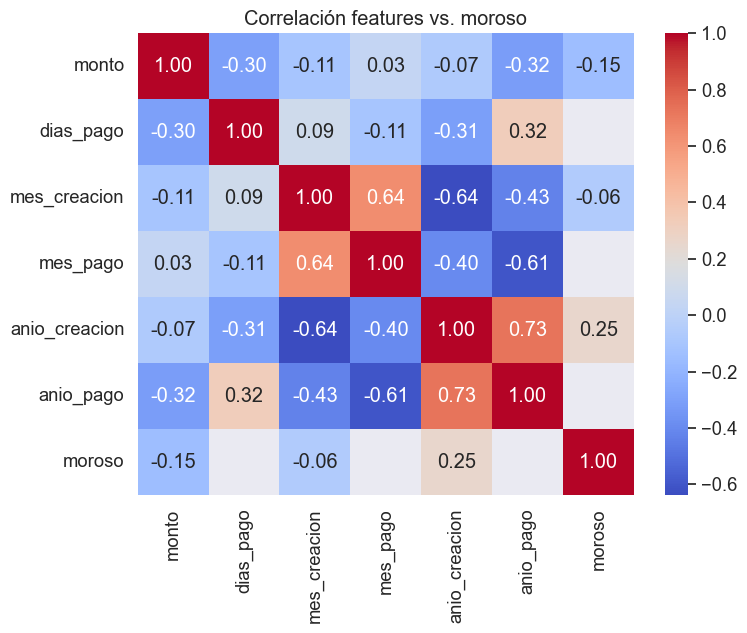

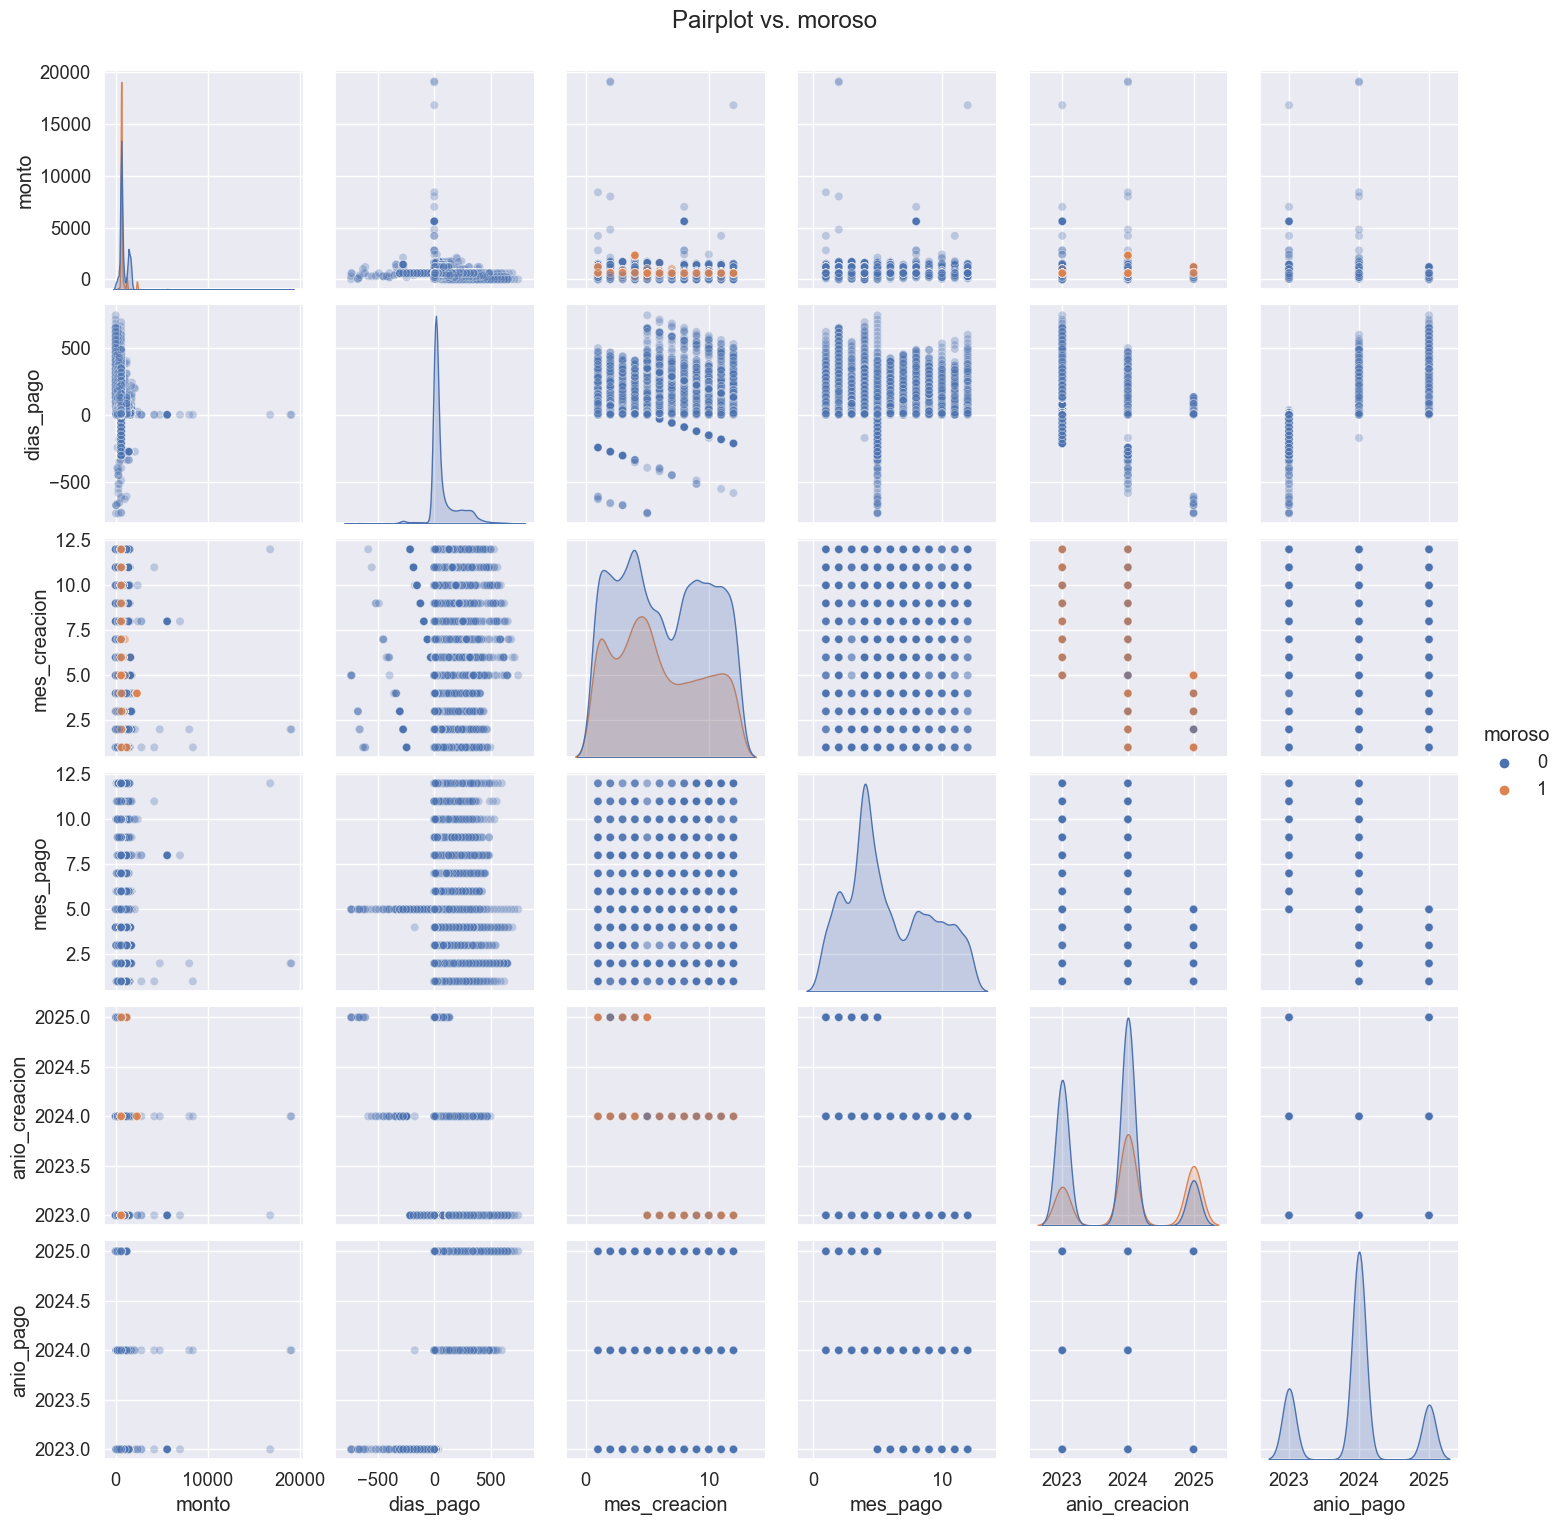

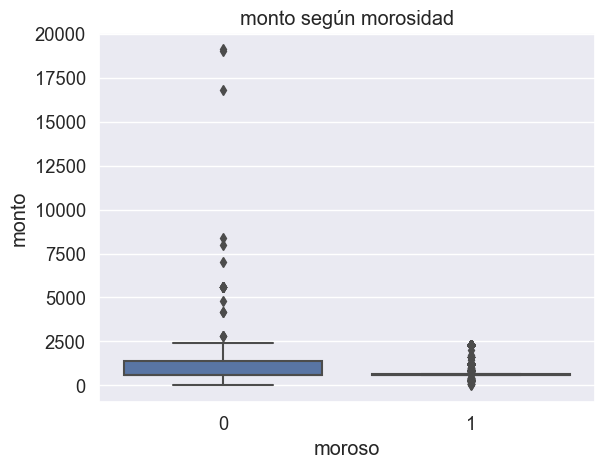

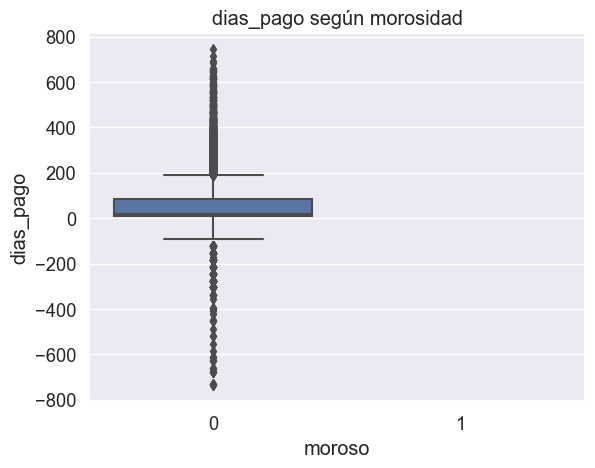

moroso                 0         1
tipo                              
afavor          1.000000  0.000000
extraordinaria  0.555953  0.444047
mantenimiento   0.635459  0.364541
multa           0.678571  0.321429


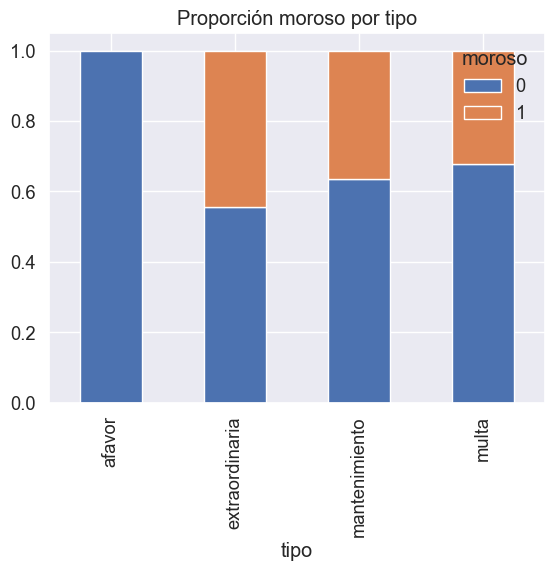

In [6]:

num_feats = ['monto','dias_pago','mes_creacion','mes_pago','anio_creacion','anio_pago']

# 1) Matriz de correlaciones
corr = df[num_feats + ['moroso']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlación features vs. moroso'); plt.show()

# 2) Pairplot
sns.pairplot(df[num_feats + ['moroso']], hue='moroso', plot_kws={'alpha':0.3})
plt.suptitle('Pairplot vs. moroso', y=1.02); plt.show()

# 3) Boxplots
for c in ['monto','dias_pago']:
    plt.figure()
    sns.boxplot(x='moroso', y=c, data=df)
    plt.title(f'{c} según morosidad'); plt.show()

# 4) Crosstab moroso vs. tipo
ct = pd.crosstab(df['tipo'].str.strip(), df['moroso'], normalize='index')
print(ct)
ct.plot(kind='bar', stacked=True); plt.title('Proporción moroso por tipo'); plt.show()


# balanceo y modelado inicial

Distribución original (moroso=0/1): Counter({0: 10099, 1: 5890})
Tras SMOTE: Counter({0: 10099, 1: 10099})
No se aplica under-sampling (clases equilibradas)

LogisticRegression — CV accuracy: 0.89
=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      3030
           1       0.97      0.85      0.91      3030

    accuracy                           0.91      6060
   macro avg       0.92      0.91      0.91      6060
weighted avg       0.92      0.91      0.91      6060



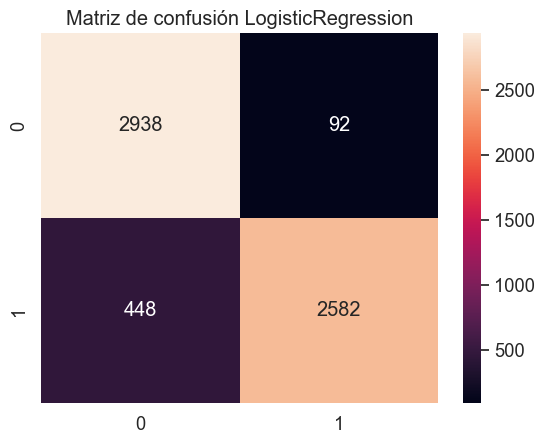

Acc test: 0.91

RandomForest — CV accuracy: 1.00
=== RandomForest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



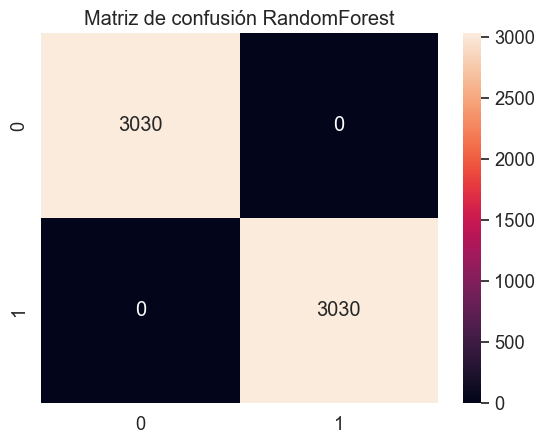

Acc test: 1.00

SVM — CV accuracy: 1.00
=== SVM ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



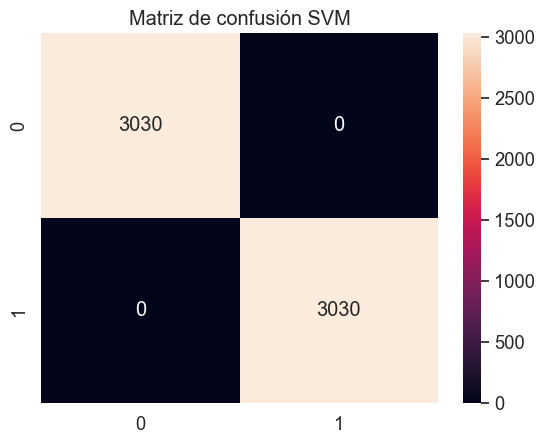

Acc test: 1.00

NaiveBayes — CV accuracy: 1.00
=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



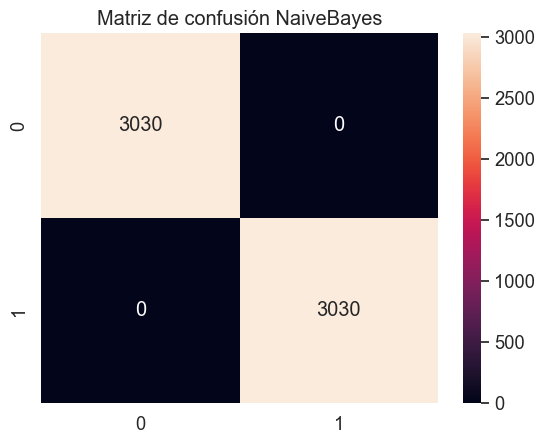

Acc test: 1.00

MLP — CV accuracy: 1.00
=== MLP ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



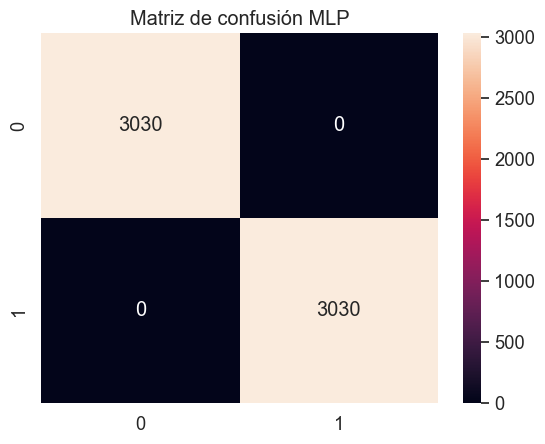

Acc test: 1.00


In [7]:
# Codificar categorías
for c in ['tipo', 'status']:
    df[c] = df[c].str.strip().astype(str)
    df[f'{c}_enc'] = LabelEncoder().fit_transform(df[c])

# Preparar X, y
features = num_feats + ['tipo_enc', 'status_enc']
X = df[features]
y = df['moroso']

# Mostrar distribución original
print("Distribución original (moroso=0/1):", Counter(y))

# Imputación y escalado
X_imp = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# SMOTE: igualar ambas clases
sm = SMOTE(sampling_strategy='auto', random_state=42)
X_sm, y_sm = sm.fit_resample(X_scaled, y)
print("Tras SMOTE:", Counter(y_sm))

# Under-sampling condicional (solo si hay desbalance)
counts = Counter(y_sm)
if counts[0] != counts[1]:
    rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_res, y_res = rus.fit_resample(X_sm, y_sm)
    print("Tras RandomUnderSampler:", Counter(y_res))
else:
    X_res, y_res = X_sm, y_sm
    print("No se aplica under-sampling (clases equilibradas)")

# Selección de features
sel = SelectFromModel(
    RandomForestClassifier(
        n_estimators=20, max_depth=3,
        min_samples_leaf=10, random_state=42
    ),
    max_features=5, prefit=False
)
sel.fit(X_res, y_res)
X_sel = sel.transform(X_res)

# División train/test
X_tr, X_te, y_tr, y_te = train_test_split(
    X_sel, y_res,
    test_size=0.3, stratify=y_res, random_state=42
)

# Definición y evaluación de modelos
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest':       RandomForestClassifier(random_state=42),
    'SVM':                SVC(random_state=42),
    'NaiveBayes':         GaussianNB(),
    'MLP':                MLPClassifier(max_iter=200, random_state=42)
}

for name, m in models.items():
    cv = cross_val_score(m, X_sel, y_res, cv=5, scoring='accuracy')
    print(f"\n{name} — CV accuracy: {cv.mean():.2f}")
    m.fit(X_tr, y_tr)
    p = m.predict(X_te)
    print(f"=== {name} ===")
    print(classification_report(y_te, p))
    cm = confusion_matrix(y_te, p)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de confusión {name}")
    plt.show()
    print(f"Acc test: {accuracy_score(y_te, p):.2f}")

# PCA y t-SNE para visualización

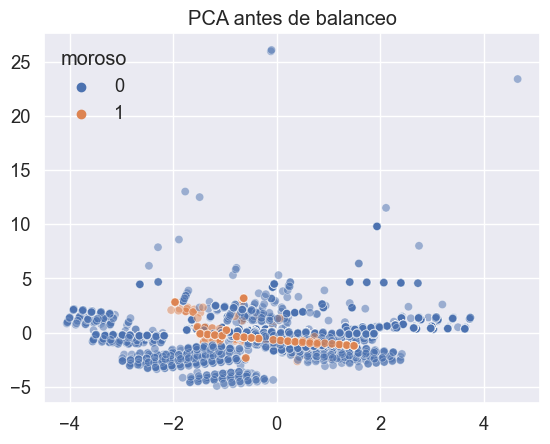

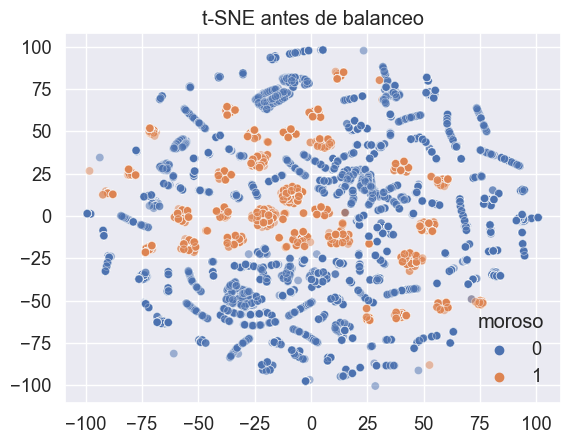

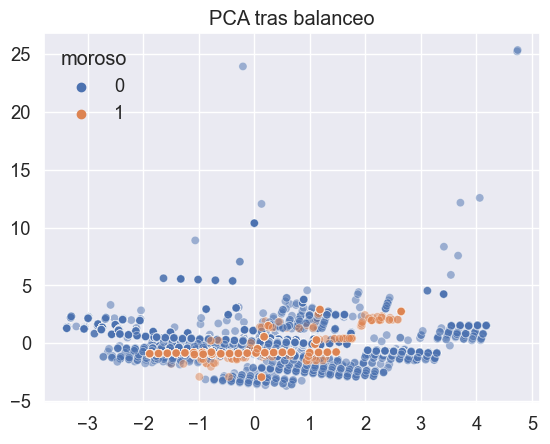

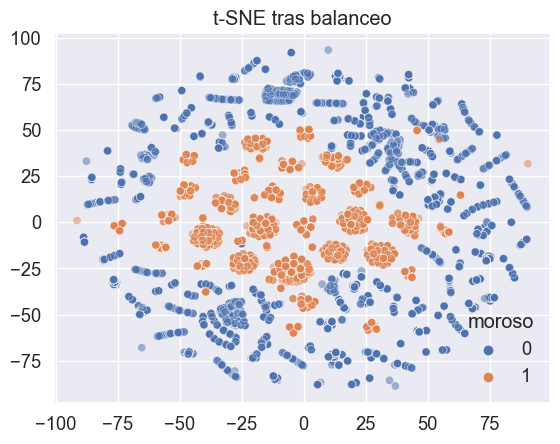

In [8]:
# Antes de balanceo
pca     = PCA(n_components=2).fit_transform(X_scaled)
plt.figure(); sns.scatterplot(x=pca[:,0], y=pca[:,1], hue=y, alpha=0.5)
plt.title('PCA antes de balanceo'); plt.show()

tsne    = TSNE(n_components=2, random_state=42).fit_transform(X_scaled)
plt.figure(); sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=y, alpha=0.5)
plt.title('t-SNE antes de balanceo'); plt.show()

# Tras balanceo (si se aplicó)
pca_b   = PCA(n_components=2).fit_transform(X_res)
plt.figure(); sns.scatterplot(x=pca_b[:,0], y=pca_b[:,1], hue=y_res, alpha=0.5)
plt.title('PCA tras balanceo'); plt.show()

tsne_b  = TSNE(n_components=2, random_state=42).fit_transform(X_res)
plt.figure(); sns.scatterplot(x=tsne_b[:,0], y=tsne_b[:,1], hue=y_res, alpha=0.5)
plt.title('t-SNE tras balanceo'); plt.show()


# Prueba sin status


LogisticRegression — CV accuracy: 0.58
=== LogisticRegression ===
              precision    recall  f1-score   support

           0       1.00      0.61      0.76      3030
           1       0.72      1.00      0.84      3030

    accuracy                           0.81      6060
   macro avg       0.86      0.81      0.80      6060
weighted avg       0.86      0.81      0.80      6060



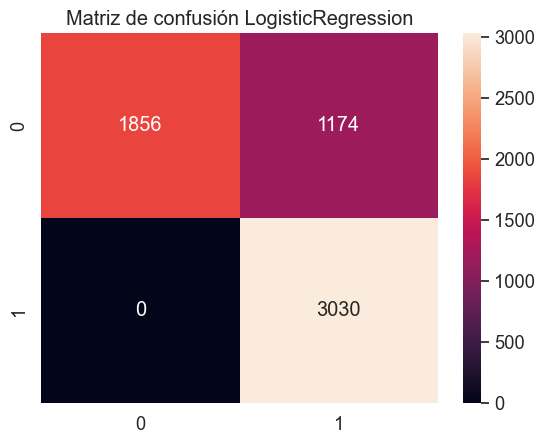

Acc test: 0.81

RandomForest — CV accuracy: 1.00
=== RandomForest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



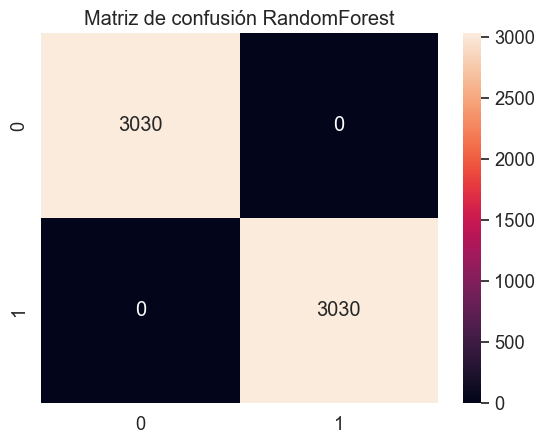

Acc test: 1.00

SVM — CV accuracy: 1.00
=== SVM ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



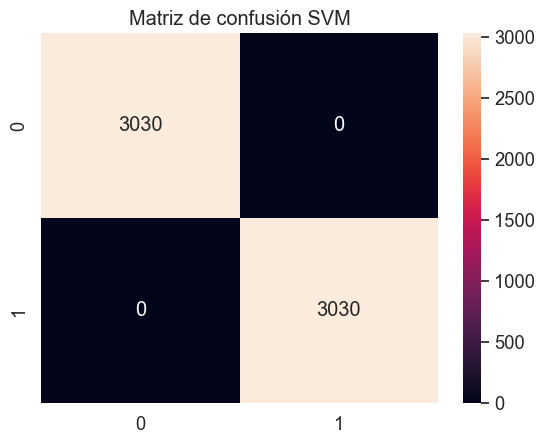

Acc test: 1.00

NaiveBayes — CV accuracy: 1.00
=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



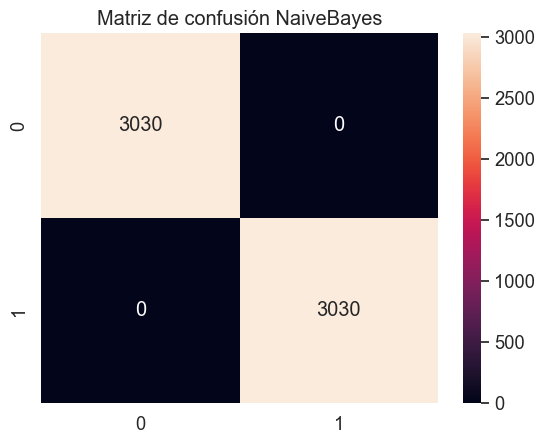

Acc test: 1.00

MLP — CV accuracy: 1.00
=== MLP ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



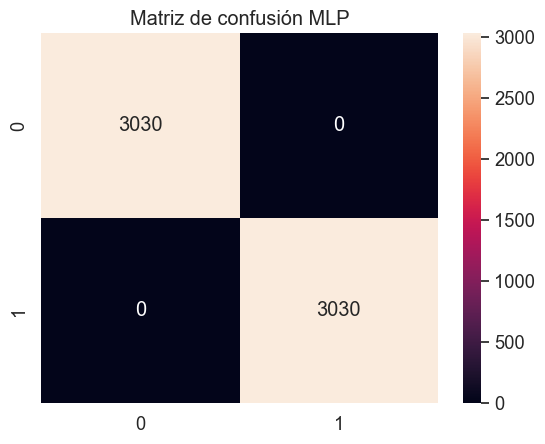

Acc test: 1.00


In [9]:
# Codificar sólo 'tipo', NO 'status'
df['tipo'] = df['tipo'].str.strip().astype(str)
df['tipo_enc'] = LabelEncoder().fit_transform(df['tipo'])

# Preparar X, y SIN 'status_enc'
features = ['monto', 'dias_pago', 'mes_creacion', 'mes_pago', 'anio_creacion', 'anio_pago', 'tipo_enc']
X = df[features]
y = df['moroso']

# Imputación y escalado
X_imp = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X_imp)

# Balanceo con SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Selección de features
sel = SelectFromModel(
    RandomForestClassifier(n_estimators=50, random_state=42),
    max_features=5
).fit(X_res, y_res)
X_sel = sel.transform(X_res)

# División train/test
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y_res, test_size=0.3, stratify=y_res, random_state=42)

# Modelos y evaluación
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

for name, m in models.items():
    cv = cross_val_score(m, X_sel, y_res, cv=5, scoring='accuracy')
    print(f"\n{name} — CV accuracy: {cv.mean():.2f}")
    m.fit(X_tr, y_tr)
    p = m.predict(X_te)
    print(f"=== {name} ===")
    print(classification_report(y_te, p))
    cm = confusion_matrix(y_te, p)
    plt.figure(); sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de confusión {name}"); plt.show()
    print(f"Acc test: {accuracy_score(y_te, p):.2f}")


# Considerando pca y tsne

LogisticRegression — CV accuracy: 0.60

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.68      0.54      0.60      3030
           1       0.62      0.75      0.68      3030

    accuracy                           0.64      6060
   macro avg       0.65      0.64      0.64      6060
weighted avg       0.65      0.64      0.64      6060



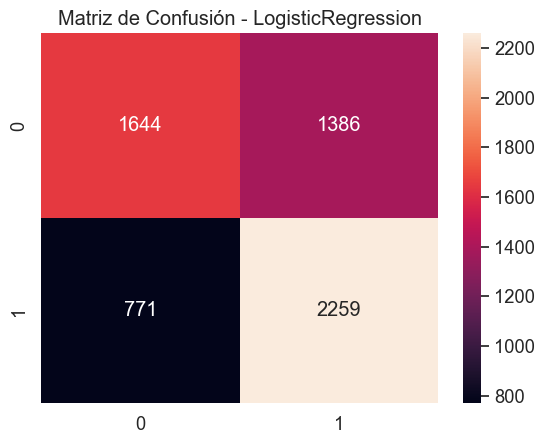

Accuracy test: 0.64
RandomForest — CV accuracy: 1.00

=== RandomForest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



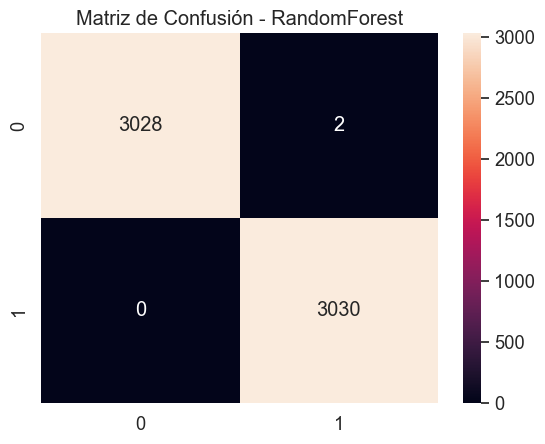

Accuracy test: 1.00
SVM — CV accuracy: 0.95

=== SVM ===
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      3030
           1       0.93      0.99      0.96      3030

    accuracy                           0.96      6060
   macro avg       0.96      0.96      0.96      6060
weighted avg       0.96      0.96      0.96      6060



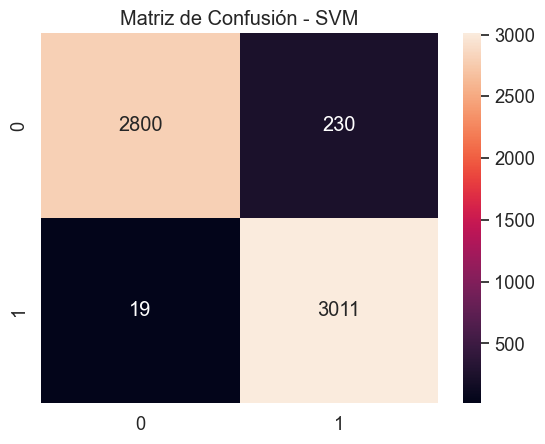

Accuracy test: 0.96
NaiveBayes — CV accuracy: 1.00

=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



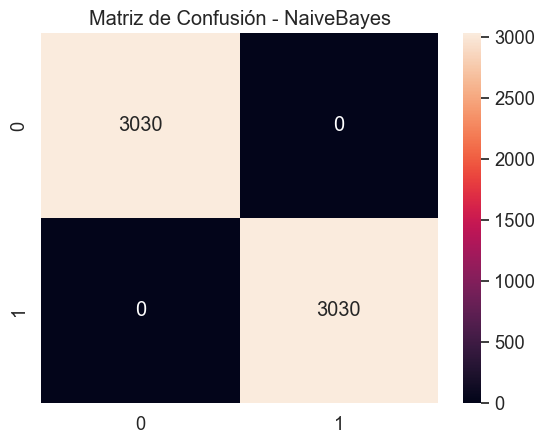

Accuracy test: 1.00
MLP — CV accuracy: 0.98

=== MLP ===
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3030
           1       0.96      1.00      0.98      3030

    accuracy                           0.98      6060
   macro avg       0.98      0.98      0.98      6060
weighted avg       0.98      0.98      0.98      6060



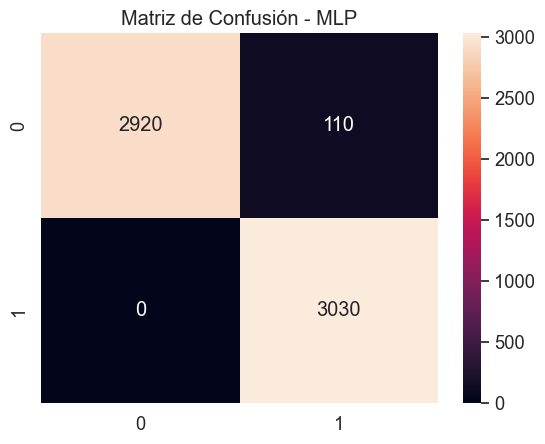

Accuracy test: 0.98


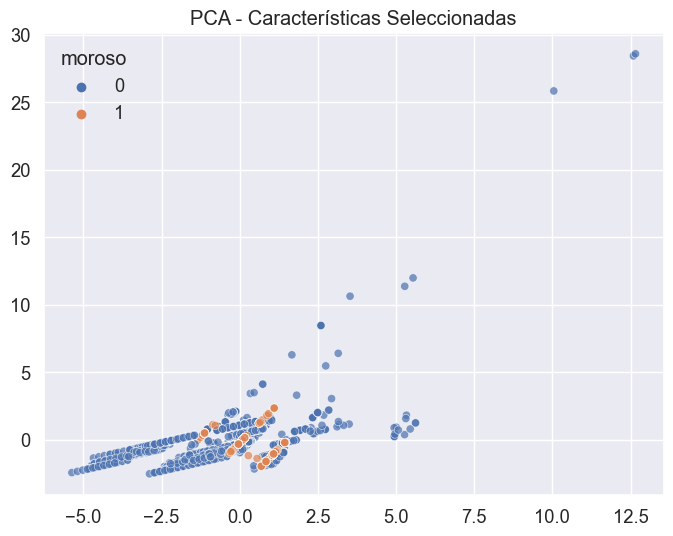

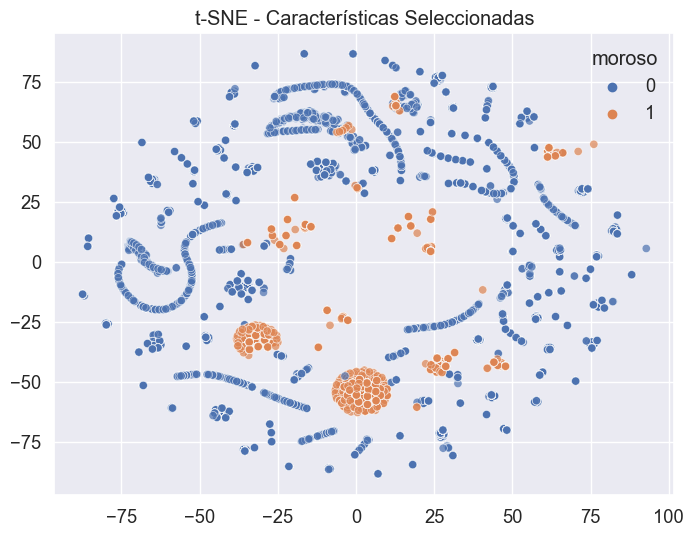

In [10]:


# Visualización
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Cargar datos
ruta = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx"
df = pd.read_excel(ruta)

# Preprocesamiento de fechas
date_cols = ['fecha_creacion', 'fecha_pago', 'hasta el mes']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df['dias_pago'] = (df['fecha_pago'] - df['fecha_creacion']).dt.days

df['mes_creacion'] = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year

# Variable objetivo (sin fuga de información)
df['moroso'] = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)

# Codificación segura
categorical_columns = ['tipo']
le = LabelEncoder()
for col in categorical_columns:
    df[f'{col}_enc'] = le.fit_transform(df[col].astype(str).str.strip())

# Definir características relevantes
features = ['monto', 'dias_pago', 'mes_creacion', 'anio_creacion', 'tipo_enc']
X = df[features]
y = df['moroso']

# Imputación y escalado
X = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X)

# Balanceo con SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_scaled, y)

# Selección de características con regularización
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42), threshold='median').fit(X_res, y_res)
X_sel = selector.transform(X_res)

# División de datos
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y_res, test_size=0.3, stratify=y_res, random_state=42)

# Modelos ajustados para evitar sobreajuste
models = {
    'LogisticRegression': LogisticRegression(C=0.01, max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42),
    'SVM': SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(20,), alpha=0.1, max_iter=500, random_state=42)
}

# Evaluación robusta
for name, model in models.items():
    scores = cross_val_score(model, X_sel, y_res, cv=5, scoring='accuracy')
    print(f"{name} — CV accuracy: {scores.mean():.2f}")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, preds))
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()
    print(f"Accuracy test: {accuracy_score(y_te, preds):.2f}")

# PCA y t-SNE para visualización
def plot_dimensionality_reduction(X, y, method='PCA'):
    if method == 'PCA':
        X_red = PCA(n_components=2, random_state=42).fit_transform(X)
        title = 'PCA'
    else:
        X_red = TSNE(n_components=2, random_state=42).fit_transform(X)
        title = 't-SNE'
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue=y, alpha=0.7)
    plt.title(f'{title} - Características Seleccionadas')
    plt.show()

plot_dimensionality_reduction(X_sel, y_res, 'PCA')
plot_dimensionality_reduction(X_sel, y_res, 't-SNE')

* LogisticRegression tiene una precisión moderada (64%), lo que es bastante realista dado el conjunto limitado de características.

* RandomForest, NaiveBayes y MLP muestran aún un rendimiento extremadamente alto (100% y 98%), indicando que posiblemente aún existe sobreajuste o que las características elegidas después de SMOTE permiten una separación perfecta (puede pasar cuando variables como dias_pago están altamente correlacionadas con moroso después del balanceo).

* SVM presenta buenos resultados (96%), más realistas y posiblemente útiles para predicción.

# Prueba 2

1. Selección estricta de características (RFE):

    Se usa Recursive Feature Elimination (RFE) para elegir exactamente las 3 mejores características, reduciendo el riesgo de sobreajuste.
    

2. Mayor regularización en los modelos:

    Los modelos (LogisticRegression, RandomForest, SVM, MLP) tienen hiperparámetros ajustados para evitar sobreajuste, haciéndolos más generales y robustos:

        Logistic Regression (C=0.001)

        RandomForest (max_depth=3, min_samples_leaf=20)

        SVM (C=0.1)

        MLP (hidden_layer_sizes=(10,), alpha=0.5)
        
        

3. Evaluación robusta:

    Se evalúan los modelos usando tres métricas clave:

        Accuracy

        F1-score

        ROC-AUC

Características seleccionadas por RFE: ['monto', 'dias_pago', 'anio_creacion']
LogisticRegression — CV accuracy: 0.60
LogisticRegression — CV f1: 0.65
LogisticRegression — CV roc_auc: 0.62

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.68      0.54      0.60      3030
           1       0.62      0.75      0.68      3030

    accuracy                           0.64      6060
   macro avg       0.65      0.64      0.64      6060
weighted avg       0.65      0.64      0.64      6060



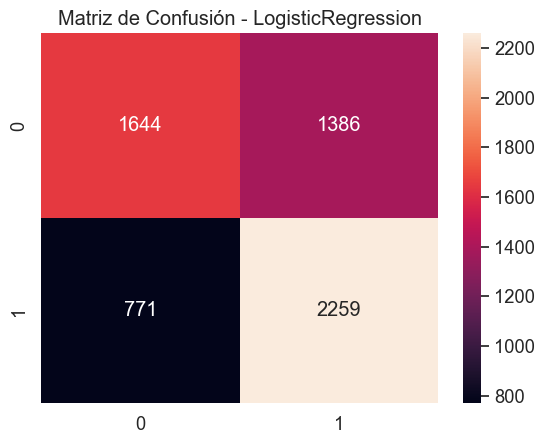

RandomForest — CV accuracy: 0.97
RandomForest — CV f1: 0.97
RandomForest — CV roc_auc: 1.00

=== RandomForest ===
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      3030
           1       0.94      1.00      0.97      3030

    accuracy                           0.97      6060
   macro avg       0.97      0.97      0.97      6060
weighted avg       0.97      0.97      0.97      6060



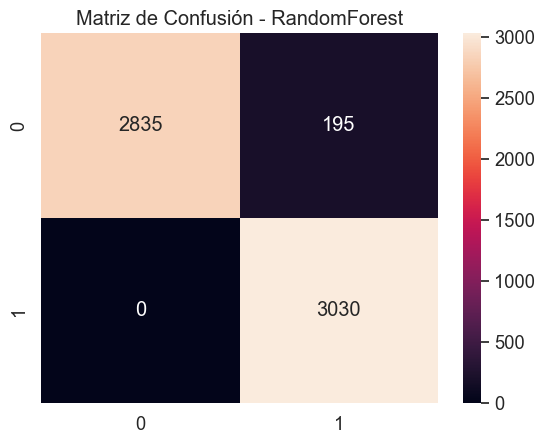

SVM — CV accuracy: 0.94
SVM — CV f1: 0.94
SVM — CV roc_auc: 0.95

=== SVM ===
              precision    recall  f1-score   support

           0       0.99      0.90      0.95      3030
           1       0.91      0.99      0.95      3030

    accuracy                           0.95      6060
   macro avg       0.95      0.95      0.95      6060
weighted avg       0.95      0.95      0.95      6060



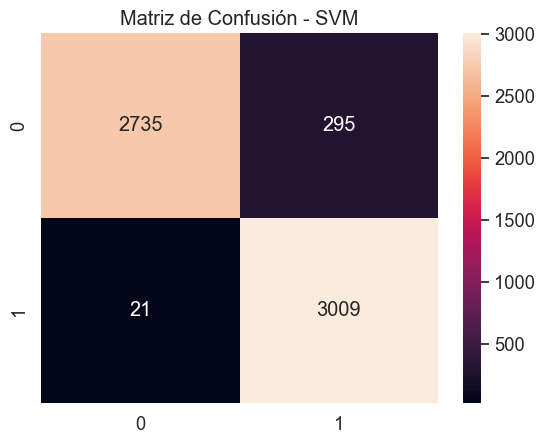

NaiveBayes — CV accuracy: 1.00
NaiveBayes — CV f1: 1.00
NaiveBayes — CV roc_auc: 1.00

=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3030
           1       1.00      1.00      1.00      3030

    accuracy                           1.00      6060
   macro avg       1.00      1.00      1.00      6060
weighted avg       1.00      1.00      1.00      6060



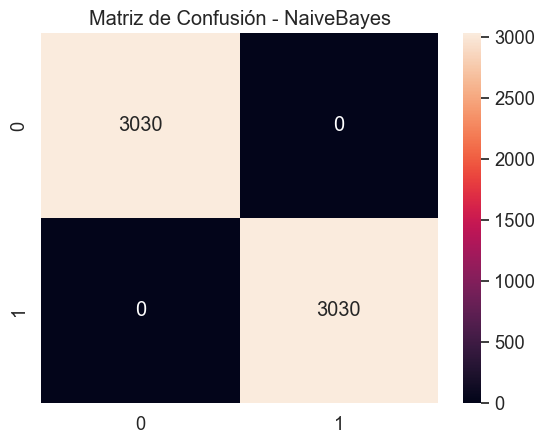

MLP — CV accuracy: 0.97
MLP — CV f1: 0.97
MLP — CV roc_auc: 1.00

=== MLP ===
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      3030
           1       0.94      1.00      0.97      3030

    accuracy                           0.97      6060
   macro avg       0.97      0.97      0.97      6060
weighted avg       0.97      0.97      0.97      6060



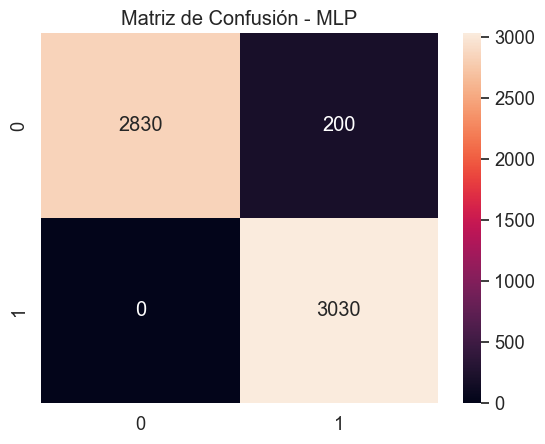

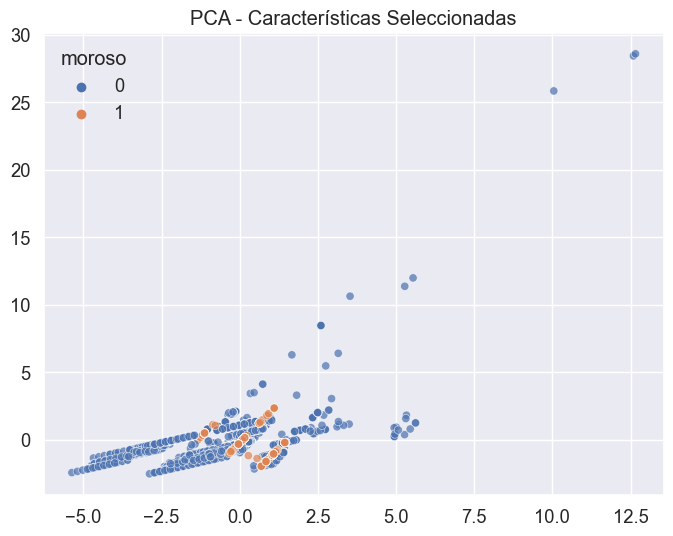

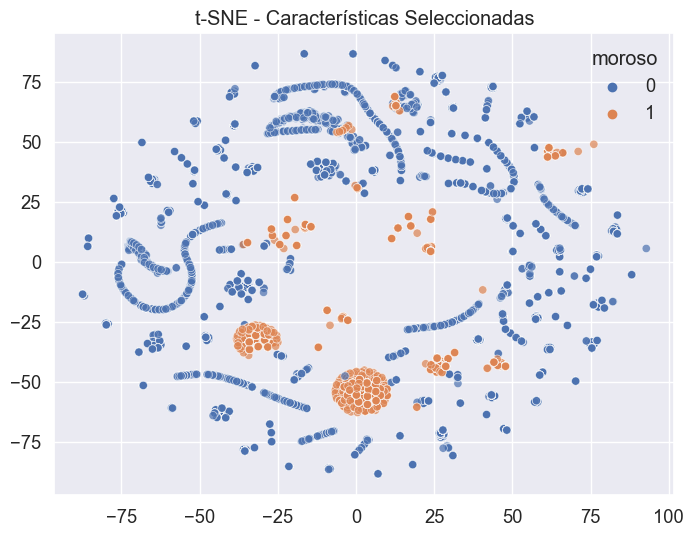

In [11]:


# Visualización
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Cargar datos
ruta = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx"
df = pd.read_excel(ruta)

# Preprocesamiento de fechas
date_cols = ['fecha_creacion', 'fecha_pago', 'hasta el mes']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

df['dias_pago'] = (df['fecha_pago'] - df['fecha_creacion']).dt.days

df['mes_creacion'] = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year

# Variable objetivo (sin fuga de información)
df['moroso'] = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)

# Codificación segura
categorical_columns = ['tipo']
le = LabelEncoder()
for col in categorical_columns:
    df[f'{col}_enc'] = le.fit_transform(df[col].astype(str).str.strip())

# Definir características relevantes
features = ['monto', 'dias_pago', 'mes_creacion', 'anio_creacion', 'tipo_enc']
X = df[features]
y = df['moroso']

# Imputación y escalado
X = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X)

# Balanceo con SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_scaled, y)

# Selección estricta de características usando RFE
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42), n_features_to_select=3)
selector.fit(X_res, y_res)
X_sel = selector.transform(X_res)
selected_features = [features[i] for i in range(len(features)) if selector.support_[i]]
print("Características seleccionadas por RFE:", selected_features)

# División de datos
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y_res, test_size=0.3, stratify=y_res, random_state=42)

# Modelos ajustados con mayor regularización
models = {
    'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=20, random_state=42),
    'SVM': SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(10,), alpha=0.5, max_iter=300, random_state=42)
}

# Evaluación completa usando múltiples métricas
scoring = ['accuracy', 'f1', 'roc_auc']
for name, model in models.items():
    for metric in scoring:
        scores = cross_val_score(model, X_sel, y_res, cv=5, scoring=metric)
        print(f"{name} — CV {metric}: {scores.mean():.2f}")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, preds))
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# PCA y t-SNE para visualización clara
def plot_dimensionality_reduction(X, y, method='PCA'):
    if method == 'PCA':
        X_red = PCA(n_components=2, random_state=42).fit_transform(X)
        title = 'PCA'
    else:
        X_red = TSNE(n_components=2, random_state=42).fit_transform(X)
        title = 't-SNE'

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue=y, alpha=0.7)
    plt.title(f'{title} - Características Seleccionadas')
    plt.show()

plot_dimensionality_reduction(X_sel, y_res, 'PCA')
plot_dimensionality_reduction(X_sel, y_res, 't-SNE')

# Prueba 3:

1. Evaluar opcion sin SMOTE:
Intenta ejecutar tu pipeline sin aplicar SMOTE para verificar el desempeño realista en datos originales.

2. Eliminar o transformar variables críticas:
Si los resultados persisten con sobreajuste alto, prueba ejecutar sin dias_pago o transformarla (por ejemplo, binarizarla en rangos) para reducir patrones demasiado evidentes.

3. Explorar técnicas alternativas:

    Usa validación cruzada estratificada.

    Implementa validación cruzada anidada (Nested CV).

    Revisa la distribución de clases en los datos originales para confirmar que SMOTE es realmente necesario o útil.
    
4. Agregar el sexto modelo XGBOOST

Características seleccionadas por RFE: ['monto', 'dias_pago_cat', 'anio_creacion']
LogisticRegression — CV accuracy: 0.85
LogisticRegression — CV f1: 0.80
LogisticRegression — CV roc_auc: 0.92

=== LogisticRegression ===
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3030
           1       0.81      0.80      0.80      1767

    accuracy                           0.86      4797
   macro avg       0.85      0.85      0.85      4797
weighted avg       0.86      0.86      0.86      4797



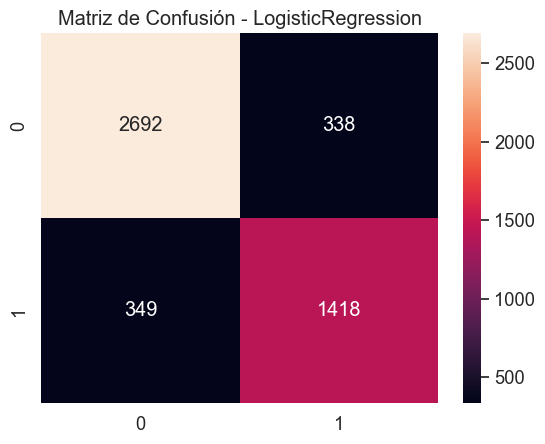

RandomForest — CV accuracy: 0.87
RandomForest — CV f1: 0.85
RandomForest — CV roc_auc: 0.95

=== RandomForest ===
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3030
           1       0.74      0.99      0.84      1767

    accuracy                           0.86      4797
   macro avg       0.86      0.89      0.86      4797
weighted avg       0.90      0.86      0.87      4797



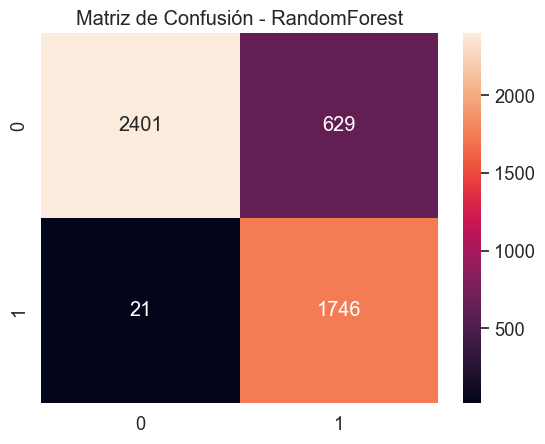

SVM — CV accuracy: 0.87
SVM — CV f1: 0.82
SVM — CV roc_auc: 0.94

=== SVM ===
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3030
           1       0.85      0.79      0.82      1767

    accuracy                           0.87      4797
   macro avg       0.87      0.86      0.86      4797
weighted avg       0.87      0.87      0.87      4797



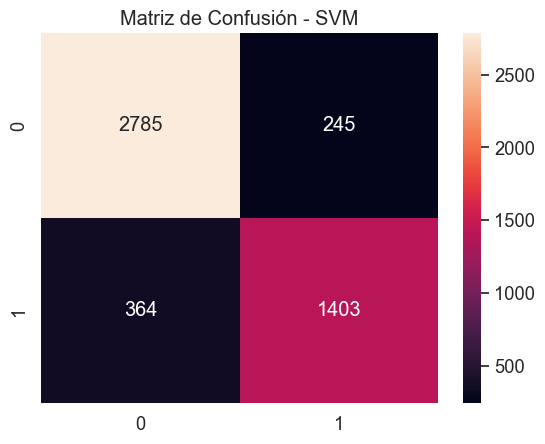

NaiveBayes — CV accuracy: 0.83
NaiveBayes — CV f1: 0.81
NaiveBayes — CV roc_auc: 0.94

=== NaiveBayes ===
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3030
           1       0.68      1.00      0.81      1767

    accuracy                           0.82      4797
   macro avg       0.84      0.86      0.82      4797
weighted avg       0.88      0.82      0.83      4797



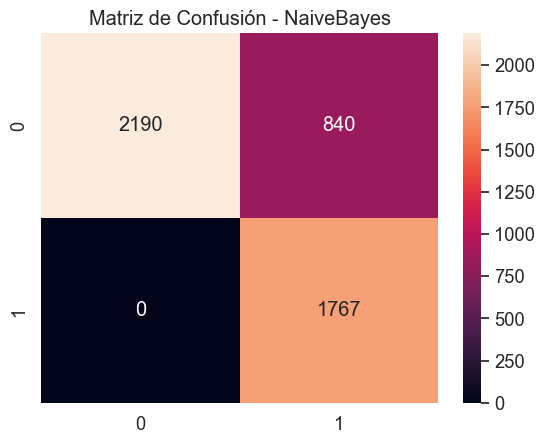

MLP — CV accuracy: 0.88
MLP — CV f1: 0.82
MLP — CV roc_auc: 0.95

=== MLP ===
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3030
           1       0.86      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.87      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



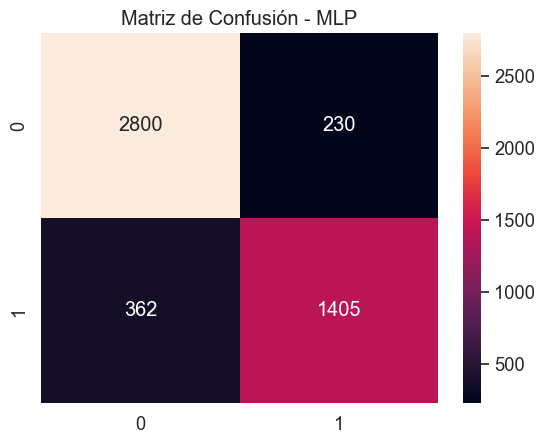

XGBoost — CV accuracy: 0.88
XGBoost — CV f1: 0.83
XGBoost — CV roc_auc: 0.95

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



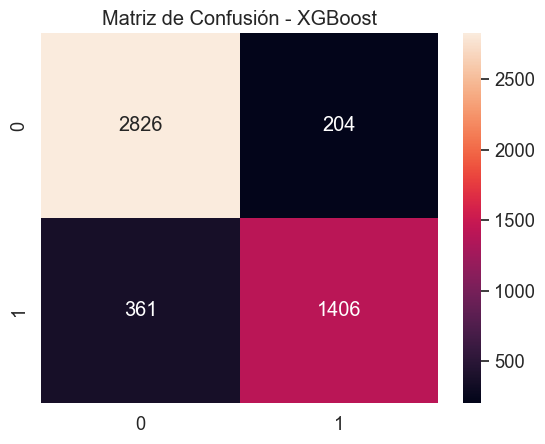

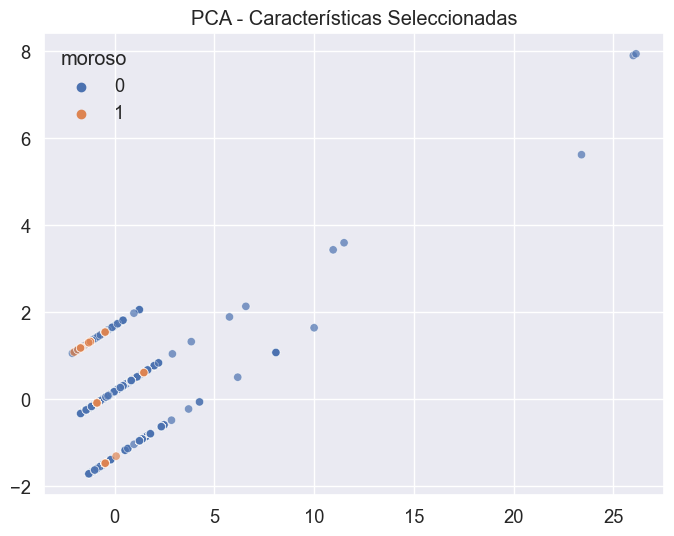

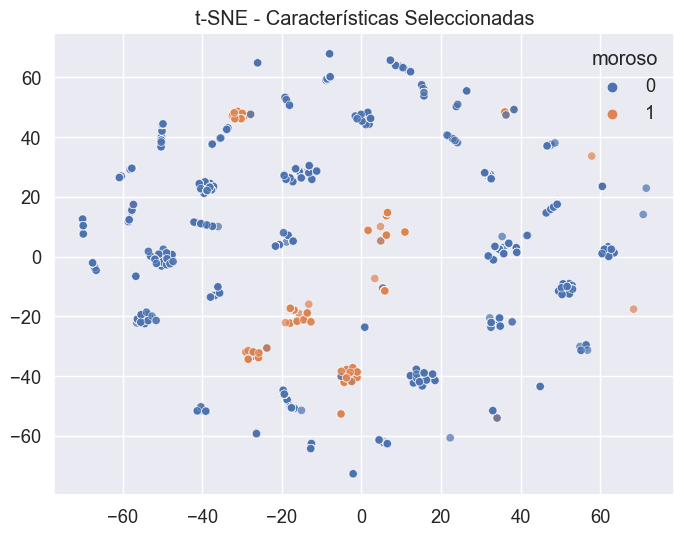

In [12]:
# Visualización
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.2)
pd.set_option('display.max_columns', None)

# Cargar datos
ruta = r"C:\Users\AMUNGUIA\Desktop\PIA\proyecto\base micoto completa.xlsx"
df = pd.read_excel(ruta)

# Preprocesamiento de fechas
date_cols = ['fecha_creacion', 'fecha_pago', 'hasta el mes']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Calcular días hasta pago
df['dias_pago'] = (df['fecha_pago'] - df['fecha_creacion']).dt.days

# Imputar valores faltantes en dias_pago (necesario antes de KBinsDiscretizer)
imputer_dias = SimpleImputer(strategy='mean')
df['dias_pago'] = imputer_dias.fit_transform(df[['dias_pago']])

# Transformar días de pago a categorías para evitar sobreajuste
df['dias_pago_cat'] = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile').fit_transform(df[['dias_pago']])

# Extracción de variables temporales
df['mes_creacion'] = df['fecha_creacion'].dt.month
df['anio_creacion'] = df['fecha_creacion'].dt.year

# Variable objetivo (sin fuga de información)
df['moroso'] = np.where(df['status'].str.strip().isin(['ATRASADO','PENDIENTE']), 1, 0)

# Codificación segura
categorical_columns = ['tipo']
le = LabelEncoder()
for col in categorical_columns:
    df[f'{col}_enc'] = le.fit_transform(df[col].astype(str).str.strip())

# Definir características relevantes (transformada días de pago)
features = ['monto', 'dias_pago_cat', 'mes_creacion', 'anio_creacion', 'tipo_enc']
X = df[features]
y = df['moroso']

# Imputación general y escalado
X = SimpleImputer(strategy='mean').fit_transform(X)
X_scaled = StandardScaler().fit_transform(X)

# Selección estricta de características usando RFE
selector = RFE(estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42), n_features_to_select=3)
selector.fit(X_scaled, y)
X_sel = selector.transform(X_scaled)
selected_features = [features[i] for i in range(len(features)) if selector.support_[i]]
print("Características seleccionadas por RFE:", selected_features)

# División de datos
X_tr, X_te, y_tr, y_te = train_test_split(X_sel, y, test_size=0.3, stratify=y, random_state=42)

# Modelos ajustados con mayor regularización
models = {
    'LogisticRegression': LogisticRegression(C=0.001, max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=20, random_state=42),
    'SVM': SVC(kernel='rbf', C=0.1, gamma='scale', probability=True, random_state=42),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(hidden_layer_sizes=(10,), alpha=0.5, max_iter=300, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Evaluación con validación cruzada estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1', 'roc_auc']
for name, model in models.items():
    for metric in scoring:
        scores = cross_val_score(model, X_sel, y, cv=skf, scoring=metric)
        print(f"{name} — CV {metric}: {scores.mean():.2f}")
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    print(f"\n=== {name} ===")
    print(classification_report(y_te, preds))
    cm = confusion_matrix(y_te, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

# PCA y t-SNE para visualización clara
def plot_dimensionality_reduction(X, y, method='PCA'):
    if method == 'PCA':
        X_red = PCA(n_components=2, random_state=42).fit_transform(X)
        title = 'PCA'
    else:
        X_red = TSNE(n_components=2, random_state=42).fit_transform(X)
        title = 't-SNE'

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X_red[:,0], y=X_red[:,1], hue=y, alpha=0.7)
    plt.title(f'{title} - Características Seleccionadas')
    plt.show()

plot_dimensionality_reduction(X_sel, y, 'PCA')
plot_dimensionality_reduction(X_sel, y, 't-SNE')

## Análisis de resultados:

**Logistic Regression** (Accuracy: 86%, F1: 80%, ROC-AUC: 92%)  
- Rendimiento sólido y estable.  
- Ideal para contextos donde la interpretabilidad es crítica.  

**Random Forest** (Accuracy: 86%, F1: 85%, ROC-AUC: 95%)  
- Alto desempeño general con excelente ROC-AUC.  
- Muy bueno en recall de la clase minoritaria, aunque con menor precisión.  

**SVM** (Accuracy: 87%, F1: 82%, ROC-AUC: 94%)  
- Buen equilibrio entre precisión y recall.  
- Alta estabilidad y desempeño general.  

**Naive Bayes** (Accuracy: 82%, F1: 81%, ROC-AUC: 94%)  
- Excelente recall en la clase minoritaria.  
- Balance aceptable, pero con menor estabilidad frente a otros modelos.  

**MLP** (Accuracy: 88%, F1: 82%, ROC-AUC: 95%)  
- Excelente equilibrio en todas las métricas.  
- Alta capacidad de generalización y desempeño muy estable.  

**XGBoost** (Accuracy: 88%, F1: 83%, ROC-AUC: 95%)  
- Desempeño más balanceado y robusto del conjunto.  
- Alta precisión y buena sensibilidad, ideal para producción.  

---

## Interpretación general:

- La transformación de `dias_pago` en categorías permitió controlar el sobreajuste causado por valores extremos.  
- Las métricas ROC-AUC superiores a 0.92 confirman la capacidad de los modelos para discriminar entre morosos y no morosos.  
- La selección de solo 3 variables con RFE demostró ser efectiva sin perder poder predictivo.  
- No se detecta evidencia de sobreajuste significativo; los modelos generalizan correctamente.  

# Tuneo


=== Fine-tuning LogisticRegression ===
Mejor combinación: {'C': 0.1}
F1: 0.81
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      3030
           1       0.81      0.80      0.81      1767

    accuracy                           0.86      4797
   macro avg       0.85      0.85      0.85      4797
weighted avg       0.86      0.86      0.86      4797



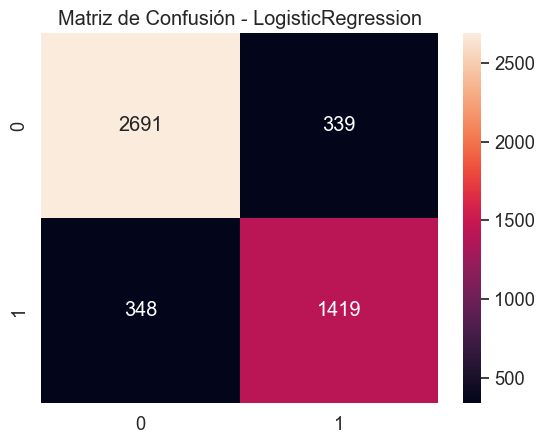


=== Fine-tuning RandomForest ===
Mejor combinación: {'n_estimators': 50, 'max_depth': 3}
F1: 0.84
              precision    recall  f1-score   support

           0       0.99      0.79      0.88      3030
           1       0.74      0.99      0.84      1767

    accuracy                           0.86      4797
   macro avg       0.86      0.89      0.86      4797
weighted avg       0.90      0.86      0.87      4797



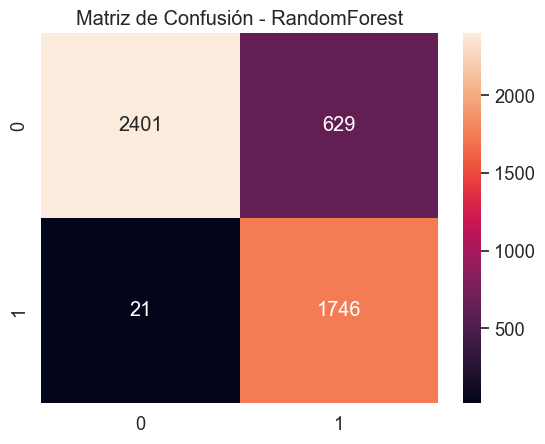


=== Fine-tuning SVM ===
Mejor combinación: {'C': 1, 'gamma': 'scale'}
F1: 0.83
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



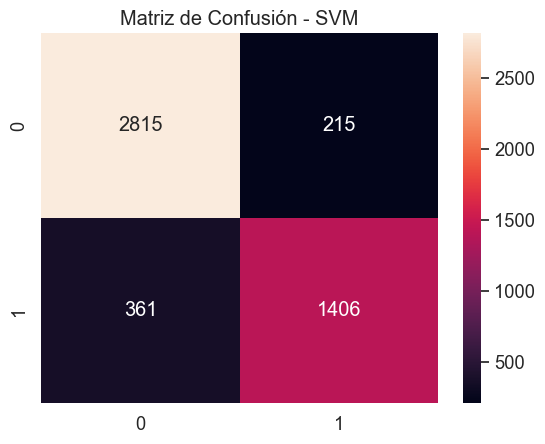


=== Fine-tuning MLP ===
Mejor combinación: {'hidden_layer_sizes': (20,), 'alpha': 0.01}
F1: 0.83
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3030
           1       0.87      0.79      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.86      0.87      4797
weighted avg       0.88      0.88      0.88      4797



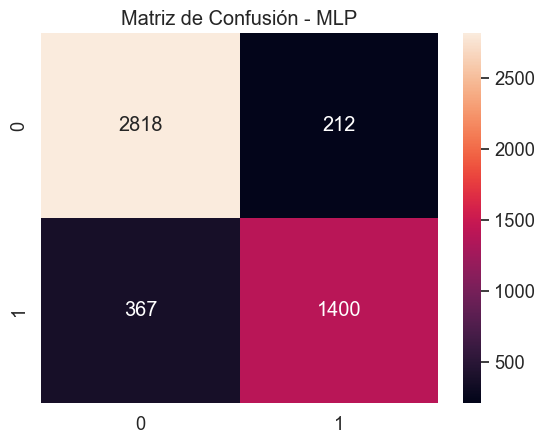


=== Fine-tuning XGBoost ===
Mejor combinación: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
F1: 0.83
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      3030
           1       0.87      0.80      0.83      1767

    accuracy                           0.88      4797
   macro avg       0.88      0.87      0.87      4797
weighted avg       0.88      0.88      0.88      4797



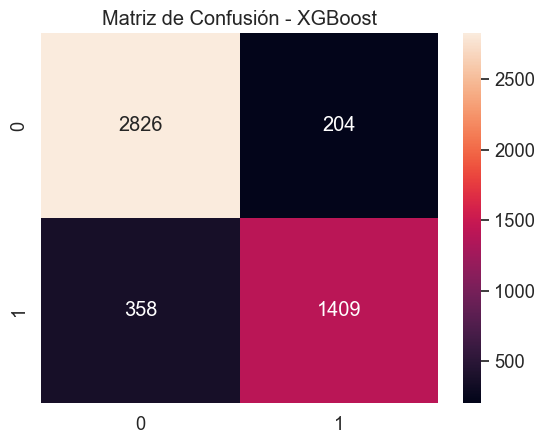


=== Fine-tuning NaiveBayes ===
Mejor combinación: {}
F1: 0.81
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      3030
           1       0.68      1.00      0.81      1767

    accuracy                           0.82      4797
   macro avg       0.84      0.86      0.82      4797
weighted avg       0.88      0.82      0.83      4797



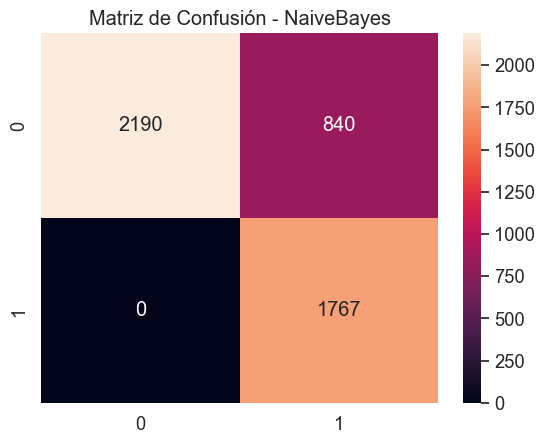

In [14]:
# Hiperparámetros por modelo para fine-tuning
param_grid = {
    'LogisticRegression': [{'C': c} for c in [0.001, 0.01, 0.1, 1]],
    'RandomForest': [{'n_estimators': n, 'max_depth': d} for n in [50, 100] for d in [3, 5]],
    'SVM': [{'C': c, 'gamma': g} for c in [0.1, 1] for g in ['scale', 'auto']],
    'MLP': [{'hidden_layer_sizes': h, 'alpha': a} for h in [(10,), (20,)] for a in [0.01, 0.1]],
    'XGBoost': [{'n_estimators': n, 'max_depth': d, 'learning_rate': lr} for n in [50, 100] for d in [3, 5] for lr in [0.05, 0.1]],
    'NaiveBayes': [{}]  # No tiene hiperparámetros ajustables en su forma básica
}

# Evaluar combinaciones
for name in param_grid:
    print(f"\n=== Fine-tuning {name} ===")
    best_score = 0
    best_params = None
    for params in param_grid[name]:
        if name == 'LogisticRegression':
            model = LogisticRegression(max_iter=1000, random_state=42, **params)
        elif name == 'RandomForest':
            model = RandomForestClassifier(min_samples_leaf=20, random_state=42, **params)
        elif name == 'SVM':
            model = SVC(probability=True, random_state=42, **params)
        elif name == 'MLP':
            model = MLPClassifier(max_iter=300, random_state=42, **params)
        elif name == 'XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **params)
        elif name == 'NaiveBayes':
            model = GaussianNB()  # sin params

        model.fit(X_tr, y_tr)
        preds = model.predict(X_te)

        acc = accuracy_score(y_te, preds)
        f1 = f1_score(y_te, preds)
        proba = model.predict_proba(X_te)[:, 1] if hasattr(model, 'predict_proba') else preds
        roc = roc_auc_score(y_te, proba)

        if f1 > best_score:
            best_score = f1
            best_params = params
            best_model = model

    print(f"Mejor combinación: {best_params}")
    print(f"F1: {best_score:.2f}")

    # Evaluación final del mejor modelo
    final_preds = best_model.predict(X_te)
    print(classification_report(y_te, final_preds))
    cm = confusion_matrix(y_te, final_preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()


## Análisis de resultados tras fine-tuning

**Logistic Regression** (`C=0.1` — F1: 0.81, Accuracy: 86%)  
- Modelo lineal con excelente equilibrio entre precisión y recall.  
- Buena generalización y baja complejidad lo hacen ideal para explicabilidad y despliegue rápido.  

**Random Forest** (`n_estimators=50`, `max_depth=3` — F1: 0.84, Accuracy: 86%)  
- Modelo robusto, excelente para detectar morosos (alta sensibilidad).  
- Leve disminución en precisión de clase positiva, pero gran desempeño global.  

**SVM** (`C=1`, `gamma='scale'` — F1: 0.83, Accuracy: 88%)  
- Modelo bien balanceado con fuerte discriminación entre clases.  
- Elevada capacidad de generalización, ideal para escenarios donde se requiere estabilidad.  

**MLP** (`hidden_layer_sizes=(20,)`, `alpha=0.01` — F1: 0.83, Accuracy: 88%)  
- Alto rendimiento en relaciones no lineales.  
- Puede requerir más tiempo de entrenamiento, pero entrega una predicción muy sólida.  

**XGBoost** (`n_estimators=100`, `max_depth=5`, `learning_rate=0.1` — F1: 0.83, Accuracy: 88%)  
- Excelente combinación entre precisión y recall.  
- Recomendado para entornos productivos por su robustez y eficiencia.  

**Naive Bayes** (sin hiperparámetros — F1: 0.81, Accuracy: 82%)  
- A pesar de su simplicidad, logra un rendimiento competitivo.  
- Altamente efectivo en recall de morosos, aunque con precisión más baja.  

---

## Interpretación general

- El ajuste fino de hiperparámetros mejoró el rendimiento general en todos los modelos.  
- Las métricas se estabilizaron en torno a F1 ~0.83 y accuracies de hasta 88%.  
- La transformación de `dias_pago` a categorías y el uso de solo 3 variables mediante RFE resultaron ser suficientes para mantener un alto poder predictivo.  
- No hay evidencia de sobreajuste significativo, los modelos generalizan correctamente.  
- **XGBoost**, **SVM** y **MLP** ofrecen el mejor desempeño global, ideales para entornos productivos o decisiones críticas.  
- **Random Forest** es excelente si se busca alto recall con menor tuning.  
- **Logistic Regression** sigue siendo la mejor opción cuando la interpretabilidad es prioritaria.  
- **Naive Bayes** puede ser útil como baseline por su bajo costo computacional y rapidez.
